In [41]:
import pandas as pd

# Load clustered data
df_clusters = pd.read_csv(r"C:\Users\Administrator\Desktop\Python\ML\ProjectPlan\clustered_output_with_vehicleinfo.csv")

# Load vehicle master with capacities
df_vehicles = pd.read_csv(r"C:\Users\Administrator\Desktop\Python\ML\DataSets\projectplancluster\vehicle_type_map_with_capacity.csv")

df_clusters.columns = df_clusters.columns.str.strip().str.replace(" ", "_")
df_vehicles.columns = df_vehicles.columns.str.strip().str.replace(" ", "_")

print("✅ Loaded data files.")



✅ Loaded data files.


In [42]:
# --- Step 2: Cluster Summary ---
cluster_summary = df_clusters.groupby("Cluster_Label").agg({
    "Total_Weight": "sum",
    "Total_Volume": "sum"
}).reset_index()

cluster_summary["Assigned_Vehicles"] = [[] for _ in range(len(cluster_summary))]
cluster_summary["Remaining_Weight"] = cluster_summary["Total_Weight"]
cluster_summary["Remaining_Volume"] = cluster_summary["Total_Volume"]

print("✅ Cluster summary prepared.")


✅ Cluster summary prepared.


In [43]:
# --- Step 3: Init Vehicle Pool ---
df_vehicles["Available"] = True
df_vehicles["Used_By_Clusters"] = [[] for _ in range(len(df_vehicles))]
print("✅ Vehicle pool initialized.")


✅ Vehicle pool initialized.


In [44]:
# --- Step 4: Assign Vehicles ---
for i, row in cluster_summary.iterrows():
    cluster_id = row["Cluster_Label"]
    rem_weight = row["Remaining_Weight"]
    rem_volume = row["Remaining_Volume"]

    print(f"\n🚚 Assigning to Cluster {cluster_id} [Need: {rem_weight}kg, {rem_volume}L]")

    for v_idx, vehicle in df_vehicles.iterrows():
        if not df_vehicles.at[v_idx, "Available"]:
            continue

        v_wt = vehicle["Weight_Capacity_(kg)"]
        v_vol = vehicle["Volume_Capacity_(L)"]

        if rem_weight <= 0 and rem_volume <= 0:
            break

        # Assign
        cluster_summary.at[i, "Assigned_Vehicles"].append(vehicle["Vehicle_ID"])
        df_vehicles.at[v_idx, "Available"] = False
        df_vehicles.at[v_idx, "Used_By_Clusters"].append(cluster_id)

        rem_weight -= v_wt
        rem_volume -= v_vol

        cluster_summary.at[i, "Remaining_Weight"] = rem_weight
        cluster_summary.at[i, "Remaining_Volume"] = rem_volume

        print(f"   ✅ Vehicle {vehicle['Vehicle_ID']} assigned. Remaining: {rem_weight:.1f}kg / {rem_volume:.1f}L")

    if rem_weight > 0 or rem_volume > 0:
        print(f"❗ Cluster {cluster_id} not fully satisfied.")



🚚 Assigning to Cluster 0 [Need: 65508.8kg, 34003.3L]
   ✅ Vehicle GJ08X2709 assigned. Remaining: 56508.8kg / -996.7L
   ✅ Vehicle GJ30X2371 assigned. Remaining: 52508.8kg / -15996.7L
   ✅ Vehicle GJ24X8239 assigned. Remaining: 43508.8kg / -50996.7L
   ✅ Vehicle GJ01X1573 assigned. Remaining: 39508.8kg / -65996.7L
   ✅ Vehicle GJ20X7043 assigned. Remaining: 30508.8kg / -100996.7L
   ✅ Vehicle GJ27X6555 assigned. Remaining: 26508.8kg / -115996.7L
   ✅ Vehicle GJ15X2258 assigned. Remaining: 22508.8kg / -130996.7L
   ✅ Vehicle GJ10X3428 assigned. Remaining: 13508.8kg / -165996.7L
   ✅ Vehicle GJ24X6673 assigned. Remaining: 9508.8kg / -180996.7L
   ✅ Vehicle GJ29X9603 assigned. Remaining: 508.8kg / -215996.7L
   ✅ Vehicle GJ27X7102 assigned. Remaining: -8491.2kg / -250996.7L

🚚 Assigning to Cluster 1 [Need: 53445.6kg, 28632.4L]
   ✅ Vehicle GJ10X3256 assigned. Remaining: 44445.6kg / -6367.6L
   ✅ Vehicle GJ29X3199 assigned. Remaining: 35445.6kg / -41367.6L
   ✅ Vehicle GJ27X9363 assigned. 

In [45]:
# --- Step 5: Explode Vehicle Assignments ---
assignments = []
for _, row in cluster_summary.iterrows():
    for vid in row["Assigned_Vehicles"]:
        assignments.append({
            "Cluster_Label": row["Cluster_Label"],
            "Vehicle_ID": vid,
            "Assigned_Vehicles": ", ".join(row["Assigned_Vehicles"])
        })

df_assignments = pd.DataFrame(assignments)
print("✅ Assignment mapping built.")


✅ Assignment mapping built.


In [46]:
# --- Step 6: Merge Full Info (Safe & Clean) ---

# Step 6.1: Merge vehicle metadata with assignments first (avoid overwriting during df_clusters merge)
df_assignments_merged = df_assignments.merge(
    df_vehicles.drop(columns=["Available", "Used_By_Clusters"]),
    on="Vehicle_ID", how="left"
)

# Step 6.2: Merge with the full cluster data
df_final = df_clusters.merge(df_assignments_merged, on="Cluster_Label", how="left")

# Step 6.3: Export result
final_path = r"C:\Users\Administrator\Desktop\Python\ML\ProjectPlan\clustered_with_vehicle_assignments_final.csv"
df_final.to_csv(final_path, index=False)

print(f"✅ Final merged dispatch saved at:\n{final_path}")


✅ Final merged dispatch saved at:
C:\Users\Administrator\Desktop\Python\ML\ProjectPlan\clustered_with_vehicle_assignments_final.csv


In [47]:
print("🔍 Columns in df_assignments:", df_assignments.columns.tolist())
print("🔍 Columns in df_vehicles:", df_vehicles.columns.tolist())
print("🔍 Columns in df_clusters:", df_clusters.columns.tolist())
print("🔍 Columns in df_final:", df_final.columns.tolist())


🔍 Columns in df_assignments: ['Cluster_Label', 'Vehicle_ID', 'Assigned_Vehicles']
🔍 Columns in df_vehicles: ['Vehicle_ID', 'Vehicle_Type', 'Capacity_Type', 'Volume_Capacity_(L)', 'Weight_Capacity_(kg)', 'Available', 'Used_By_Clusters']
🔍 Columns in df_clusters: ['Assignment_ID', 'Product_ID', 'Urgent_Flag', 'Dispatch_Window', 'Delivery_Window', 'Unit_Weight_(kg)', 'Unit_Volume_(L)', 'Fragile_Flag', 'Temp_Sensitive_Flag', 'Quantity_Assigned', 'Total_Weight', 'Total_Volume', 'Priority_Label', 'Cluster_Label', 'Vehicle_ID', 'Main_Cluster_Label', 'Handling_Group', 'Vehicle_Type', 'Capacity_Type', 'Volume_Capacity_(L)', 'Weight_Capacity_(kg)']
🔍 Columns in df_final: ['Assignment_ID', 'Product_ID', 'Urgent_Flag', 'Dispatch_Window', 'Delivery_Window', 'Unit_Weight_(kg)', 'Unit_Volume_(L)', 'Fragile_Flag', 'Temp_Sensitive_Flag', 'Quantity_Assigned', 'Total_Weight', 'Total_Volume', 'Priority_Label', 'Cluster_Label', 'Vehicle_ID_x', 'Main_Cluster_Label', 'Handling_Group', 'Vehicle_Type_x', 'Capa

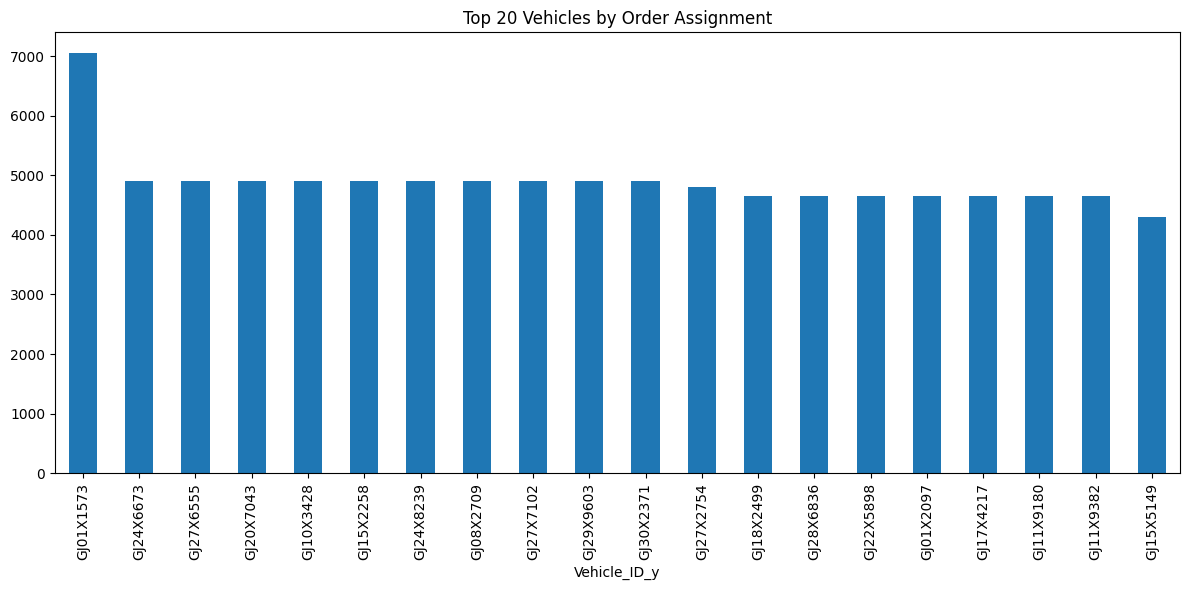

In [49]:
# Group by Vehicle and count assigned orders + clusters served
vehicle_usage_summary = df_final.groupby("Vehicle_ID_y").agg({
    "Cluster_Label": "nunique",            # How many unique clusters it served
    "Assignment_ID": "count"               # How many total orders it was assigned
}).rename(columns={
    "Cluster_Label": "Clusters_Served",
    "Assignment_ID": "Total_Orders_Assigned"
}).reset_index()


import matplotlib.pyplot as plt

vehicle_usage_summary.sort_values("Total_Orders_Assigned", ascending=False).head(20).plot(
    x="Vehicle_ID_y", y="Total_Orders_Assigned", kind="bar", figsize=(12, 6),
    title="Top 20 Vehicles by Order Assignment", legend=False
)
plt.tight_layout()
plt.show()


In [50]:
vehicle_usage_summary = df_final.groupby("Vehicle_ID_y").agg({
    "Cluster_Label": "nunique",
    "Assignment_ID": "count"
}).rename(columns={
    "Cluster_Label": "Clusters_Served",
    "Assignment_ID": "Total_Orders_Assigned"
}).reset_index()

print(vehicle_usage_summary.head())


  Vehicle_ID_y  Clusters_Served  Total_Orders_Assigned
0    GJ01X1085                1                   2716
1    GJ01X1573                2                   7048
2    GJ01X2097                1                   4648
3    GJ02X6383                1                   2652
4    GJ04X2061                1                   2716
